In [1]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

In [2]:
file_id = "1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Download to local path
output = "KlasifikasiUTS.csv"
gdown.download(url, output, quiet=False)

# Then read with pandas
df = pd.read_csv(output)
print(df.shape)

# Display basic information
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nStatistical Summary:")
print(df.describe())

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?export=download&id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=2355cc8a-18df-437e-8d4c-0aa904fab127
To: /content/KlasifikasiUTS.csv
100%|██████████| 151M/151M [00:01<00:00, 82.1MB/s]


(284807, 31)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-n

# Pembersihan data

In [13]:
# ===== EXTENDED PIPELINE: DATA EXPLORATION & PROBLEM TYPE DETECTION =====

# First, let's examine the target column to determine if this is classification or regression
print("=== DATA EXPLORATION ===")
print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

# Find the first integer column (target as specified)
int_columns = df.select_dtypes(include=['int']).columns
if len(int_columns) > 0:
    target_col = int_columns[0]
    print(f"\nTarget column: {target_col}")
    print(f"Target unique values: {df[target_col].nunique()}")
    print(f"Target value distribution:\n{df[target_col].value_counts().sort_index()}")

    # Determine if classification or regression based on target characteristics
    unique_values = df[target_col].nunique()
    is_classification = unique_values <= 20 and df[target_col].min() >= 0

    if is_classification:
        print(f"\n*** DETECTED: CLASSIFICATION PROBLEM ***")
        print(f"Number of classes: {unique_values}")
        problem_type = "classification"
    else:
        print(f"\n*** DETECTED: REGRESSION PROBLEM ***")
        problem_type = "regression"
else:
    print("No integer columns found for target!")
    exit()

# ===== 1. DATA COLLECTION & CLEANING =====
print("\n=== DATA CLEANING ===")

# Check for missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values
df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Dataset shape after cleaning: {df_clean.shape}")

=== DATA EXPLORATION ===
Dataset shape: (284807, 31)
Column names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Target column: Class
Target unique values: 2
Target value distribution:
Class
0    284315
1       492
Name: count, dtype: int64

*** 

# Feature Enginering

In [14]:
print("\n=== FEATURE ENGINEERING ===")

# Separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle categorical and numerical features separately
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create feature engineering pipeline
X_processed = X.copy()

# Process categorical features
if categorical_features:
    print("Processing categorical features...")
    # Label encoding for binary categorical features
    # One-hot encoding for multi-class categorical features

    for col in categorical_features:
        unique_vals = X_processed[col].nunique()
        if unique_vals == 2:
            # Binary categorical - use Label Encoding
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))
            print(f"Label encoded: {col}")
        elif unique_vals <= 10:
            # Multi-class categorical with few categories - use One-Hot Encoding
            dummies = pd.get_dummies(X_processed[col], prefix=col, drop_first=True)
            X_processed = pd.concat([X_processed.drop(columns=[col]), dummies], axis=1)
            print(f"One-hot encoded: {col}")
        else:
            # Too many categories - use Label Encoding
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))
            print(f"Label encoded (high cardinality): {col}")

# Convert to numerical
X_processed = X_processed.select_dtypes(include=[np.number])

print(f"Final feature matrix shape: {X_processed.shape}")

# ===== SPLIT DATA =====
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42,
    stratify=y if problem_type == "classification" else None
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# For classification, prepare labels
if problem_type == "classification":
    n_classes = len(np.unique(y))
    print(f"Number of classes: {n_classes}")

    # Convert to categorical for multi-class
    if n_classes > 2:
        y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
        y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
    else:
        y_train_cat = y_train.values
        y_test_cat = y_test.values


=== FEATURE ENGINEERING ===
Features shape: (284807, 30)
Target shape: (284807,)
Numerical features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Categorical features: []
Final feature matrix shape: (284807, 30)
Training set: (227845, 30)
Test set: (56962, 30)
Number of classes: 2


# TENSORFLOW/KERAS MODEL

In [15]:
print("\n=== BUILDING TENSORFLOW MODEL ===")

def create_tensorflow_model(input_dim, problem_type, n_classes=None):
    model = keras.Sequential([
        # Input layer with batch normalization
        layers.Dense(512, input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Hidden layers with batch normalization and dropout
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(
            1 if problem_type == "regression" or (problem_type == "classification" and n_classes == 2)
            else n_classes,
            activation='linear' if problem_type == "regression"
            else ('sigmoid' if n_classes == 2 else 'softmax')
        )
    ])

    return model

# Create and compile model
tf_model = create_tensorflow_model(
    X_train_scaled.shape[1],
    problem_type,
    n_classes if problem_type == "classification" else None
)

# Configure optimizer with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# Modern optimizer with weight decay
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

# Compile model
if problem_type == "regression":
    tf_model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
else:
    tf_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy',
        metrics=['accuracy']
    )

# Add L1/L2 regularization to layers
for layer in tf_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = keras.regularizers.L1L2(l1=1e-5, l2=1e-4)

tf_model.summary()

# Callbacks
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_tf_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("Training TensorFlow model...")
tf_history = tf_model.fit(
    X_train_scaled, y_train_cat if problem_type == "classification" else y_train,
    validation_data=(X_test_scaled, y_test_cat if problem_type == "classification" else y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks_list,
    verbose=1
)


=== BUILDING TENSORFLOW MODEL ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        15,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,257 (751.00 KB)

 Trainable params: 190,337 (743.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

Training TensorFlow model...
Epoch 1/100
3556/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9623 - loss: 0.0933
Epoch 1: val_loss improved from inf to 0.00743, saving model to best_tf_model.h5


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - accuracy: 0.9623 - loss: 0.0932 - val_accuracy: 0.9993 - val_loss: 0.0074 - learning_rate: 2.3960e-04
Epoch 2/100
3557/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9993 - loss: 0.0041
Epoch 2: val_loss improved from 0.00743 to 0.00607, saving model to best_tf_model.h5


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9993 - val_loss: 0.0061 - learning_rate: 5.5113e-05
Epoch 3/100
3559/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0037
Epoch 3: val_loss improved from 0.00607 to 0.00576, saving model to best_tf_model.h5


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9993 - val_loss: 0.0058 - learning_rate: 1.3205e-05
Epoch 4/100
3559/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0036
Epoch 4: val_loss did not improve from 0.00576
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 84s 13ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0058 - learning_rate: 3.0375e-06
Epoch 5/100
3558/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0037
Epoch 5: val_loss improved from 0.00576 to 0.00571, saving model to best_tf_model.h5


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9993 - val_loss: 0.0057 - learning_rate: 6.9868e-07
Epoch 6/100
3558/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9994 - loss: 0.0035
Epoch 6: val_loss did not improve from 0.00571
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0057 - learning_rate: 1.6741e-07
Epoch 7/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0034
Epoch 7: val_loss improved from 0.00571 to 0.00568, saving model to best_tf_model.h5


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9993 - val_loss: 0.0057 - learning_rate: 3.8507e-08
Epoch 8/100
3558/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0035
Epoch 8: val_loss did not improve from 0.00568
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0058 - learning_rate: 9.2263e-09
Epoch 9/100
3560/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0036
Epoch 9: val_loss did not improve from 0.00568
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0057 - learning_rate: 2.1222e-09
Epoch 10/100
3559/3561 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0037
Epoch 10: val_loss did not improve from 0.00568
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9993 - val_loss: 0.0057 - learning_rate: 4.

# PYTORCH MODEL

In [16]:
print("\n=== BUILDING PYTORCH MODEL ===")

class PyTorchMLP(nn.Module):
    def __init__(self, input_dim, problem_type, n_classes=None):
        super(PyTorchMLP, self).__init__()
        self.problem_type = problem_type

        # Define layers
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.2)

        # Output layer
        if problem_type == "regression":
            self.output = nn.Linear(64, 1)
        else:
            self.output = nn.Linear(64, 1 if n_classes == 2 else n_classes)

        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through layers
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.output(x)

        # Apply activation based on problem type
        if self.problem_type == "classification":
            if self.output.out_features == 1:
                x = self.sigmoid(x)
            else:
                x = self.softmax(x)

        return x

# Create PyTorch model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

pytorch_model = PyTorchMLP(
    X_train_scaled.shape[1],
    problem_type,
    n_classes if problem_type == "classification" else None
).to(device)

# Loss function and optimizer
if problem_type == "regression":
    criterion = nn.MSELoss()
else:
    criterion = nn.BCELoss() if n_classes == 2 else nn.CrossEntropyLoss()

optimizer_pytorch = optim.AdamW(
    pytorch_model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_pytorch, gamma=0.96)

# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

if problem_type == "regression":
    y_train_tensor = torch.FloatTensor(y_train.values).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).to(device)
else:
    y_train_tensor = torch.LongTensor(y_train.values).to(device)
    y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Training loop for PyTorch
print("Training PyTorch model...")
pytorch_model.train()
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(100):
    # Training
    optimizer_pytorch.zero_grad()
    outputs = pytorch_model(X_train_tensor)

    if problem_type == "regression":
        loss = criterion(outputs.squeeze(), y_train_tensor)
    else:
        if n_classes == 2:
            loss = criterion(outputs.squeeze(), y_train_tensor.float())
        else:
            loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer_pytorch.step()
    train_losses.append(loss.item())

    # Validation
    pytorch_model.eval()
    with torch.no_grad():
        val_outputs = pytorch_model(X_test_tensor)
        if problem_type == "regression":
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        else:
            if n_classes == 2:
                val_loss = criterion(val_outputs.squeeze(), y_test_tensor.float())
            else:
                val_loss = criterion(val_outputs, y_test_tensor)

        val_losses.append(val_loss.item())

    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # Save best model
        torch.save(pytorch_model.state_dict(), 'best_pytorch_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    # Learning rate scheduling
    scheduler.step()
    pytorch_model.train()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load best model
pytorch_model.load_state_dict(torch.load('best_pytorch_model.pth'))


=== BUILDING PYTORCH MODEL ===
Using device: cpu
Training PyTorch model...
Epoch 0: Train Loss: 0.5837, Val Loss: 0.7046
Epoch 10: Train Loss: 0.3996, Val Loss: 0.5872
Epoch 20: Train Loss: 0.3280, Val Loss: 0.4462
Epoch 30: Train Loss: 0.2918, Val Loss: 0.3540
Epoch 40: Train Loss: 0.2718, Val Loss: 0.3107
Epoch 50: Train Loss: 0.2579, Val Loss: 0.2869
Epoch 60: Train Loss: 0.2507, Val Loss: 0.2731
Epoch 70: Train Loss: 0.2459, Val Loss: 0.2647
Epoch 80: Train Loss: 0.2420, Val Loss: 0.2595
Epoch 90: Train Loss: 0.2399, Val Loss: 0.2563


<All keys matched successfully>

# MODEL EVALUATION

In [17]:
print("\n=== MODEL EVALUATION ===")

# Get predictions from both models
print("Getting predictions...")

# TensorFlow predictions
tf_predictions = tf_model.predict(X_test_scaled, verbose=0)
if problem_type == "classification":
    if n_classes > 2:
        tf_pred_classes = np.argmax(tf_predictions, axis=1)
        tf_pred_proba = tf_predictions
    else:
        tf_pred_classes = (tf_predictions > 0.5).astype(int).flatten()
        tf_pred_proba = tf_predictions.flatten()
else:
    tf_pred_values = tf_predictions.flatten()

# PyTorch predictions
pytorch_model.eval()
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_tensor).cpu().numpy()

if problem_type == "classification":
    if n_classes > 2:
        pytorch_pred_classes = np.argmax(pytorch_predictions, axis=1)
        pytorch_pred_proba = pytorch_predictions
    else:
        pytorch_pred_classes = (pytorch_predictions > 0.5).astype(int).flatten()
        pytorch_pred_proba = pytorch_predictions.flatten()
else:
    pytorch_pred_values = pytorch_predictions.flatten()

# ===== EVALUATION METRICS =====
if problem_type == "classification":
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.metrics import roc_auc_score, roc_curve

    print("\n=== CLASSIFICATION METRICS ===")

    # TensorFlow metrics
    tf_accuracy = accuracy_score(y_test, tf_pred_classes)
    tf_precision = precision_score(y_test, tf_pred_classes, average='weighted')
    tf_recall = recall_score(y_test, tf_pred_classes, average='weighted')
    tf_f1 = f1_score(y_test, tf_pred_classes, average='weighted')

    # PyTorch metrics
    pytorch_accuracy = accuracy_score(y_test, pytorch_pred_classes)
    pytorch_precision = precision_score(y_test, pytorch_pred_classes, average='weighted')
    pytorch_recall = recall_score(y_test, pytorch_pred_classes, average='weighted')
    pytorch_f1 = f1_score(y_test, pytorch_pred_classes, average='weighted')

    # Print results
    print("TensorFlow Model:")
    print(f"  Accuracy:  {tf_accuracy:.4f}")
    print(f"  Precision: {tf_precision:.4f}")
    print(f"  Recall:    {tf_recall:.4f}")
    print(f"  F1-Score:  {tf_f1:.4f}")

    print("\nPyTorch Model:")
    print(f"  Accuracy:  {pytorch_accuracy:.4f}")
    print(f"  Precision: {pytorch_precision:.4f}")
    print(f"  Recall:    {pytorch_recall:.4f}")
    print(f"  F1-Score:  {pytorch_f1:.4f}")

    # ROC-AUC (for binary classification or one-vs-rest for multi-class)
    if n_classes == 2:
        tf_auc = roc_auc_score(y_test, tf_pred_proba)
        pytorch_auc = roc_auc_score(y_test, pytorch_pred_proba)
        print(f"\nTensorFlow AUC: {tf_auc:.4f}")
        print(f"PyTorch AUC: {pytorch_auc:.4f}")
    else:
        tf_auc = roc_auc_score(y_test, tf_pred_proba, multi_class='ovr')
        pytorch_auc = roc_auc_score(y_test, pytorch_pred_proba, multi_class='ovr')
        print(f"\nTensorFlow AUC (OvR): {tf_auc:.4f}")
        print(f"PyTorch AUC (OvR): {pytorch_auc:.4f}")

else:  # Regression
    print("\n=== REGRESSION METRICS ===")

    # TensorFlow metrics
    tf_mse = mean_squared_error(y_test, tf_pred_values)
    tf_mae = mean_absolute_error(y_test, tf_pred_values)
    tf_r2 = r2_score(y_test, tf_pred_values)
    tf_rmse = np.sqrt(tf_mse)

    # PyTorch metrics
    pytorch_mse = mean_squared_error(y_test, pytorch_pred_values)
    pytorch_mae = mean_absolute_error(y_test, pytorch_pred_values)
    pytorch_r2 = r2_score(y_test, pytorch_pred_values)
    pytorch_rmse = np.sqrt(pytorch_mse)

    # Print results
    print("TensorFlow Model:")
    print(f"  MSE:  {tf_mse:.4f}")
    print(f"  RMSE: {tf_rmse:.4f}")
    print(f"  MAE:  {tf_mae:.4f}")
    print(f"  R²:   {tf_r2:.4f}")

    print("\nPyTorch Model:")
    print(f"  MSE:  {pytorch_mse:.4f}")
    print(f"  RMSE: {pytorch_rmse:.4f}")
    print(f"  MAE:  {pytorch_mae:.4f}")
    print(f"  R²:   {pytorch_r2:.4f}")


=== MODEL EVALUATION ===
Getting predictions...

=== CLASSIFICATION METRICS ===
TensorFlow Model:
  Accuracy:  0.9993
  Precision: 0.9993
  Recall:    0.9993
  F1-Score:  0.9993

PyTorch Model:
  Accuracy:  0.9992
  Precision: 0.9993
  Recall:    0.9992
  F1-Score:  0.9993

TensorFlow AUC: 0.9782
PyTorch AUC: 0.9379


# visualisasi


=== CREATING VISUALIZATIONS ===


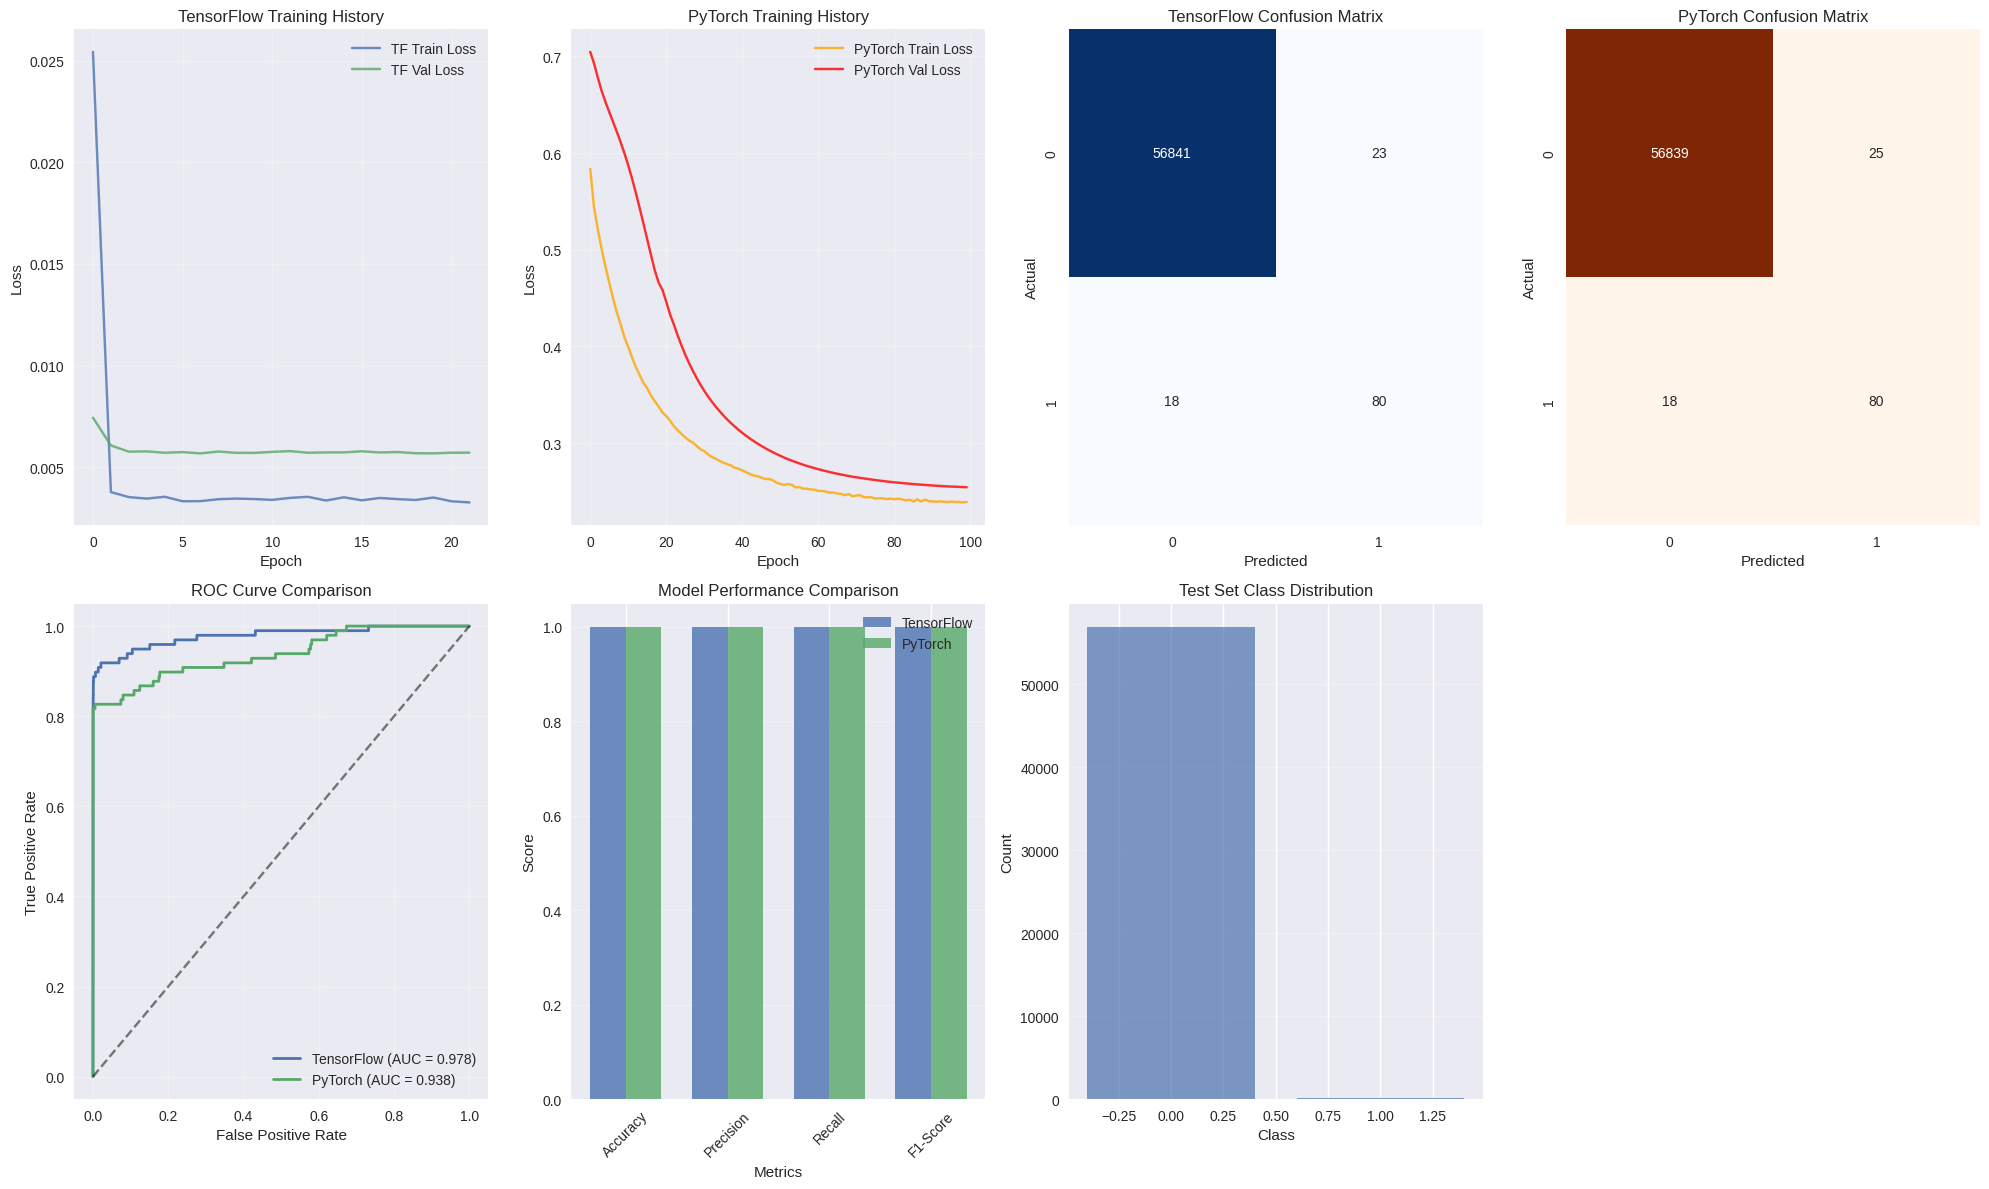

In [18]:
print("\n=== CREATING VISUALIZATIONS ===")

# Set up the plotting
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 12))

if problem_type == "classification":
    # 1. Training History
    plt.subplot(2, 4, 1)
    plt.plot(tf_history.history['loss'], label='TF Train Loss', alpha=0.8)
    plt.plot(tf_history.history['val_loss'], label='TF Val Loss', alpha=0.8)
    plt.title('TensorFlow Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 4, 2)
    plt.plot(train_losses, label='PyTorch Train Loss', alpha=0.8, color='orange')
    plt.plot(val_losses, label='PyTorch Val Loss', alpha=0.8, color='red')
    plt.title('PyTorch Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Confusion Matrices
    plt.subplot(2, 4, 3)
    cm_tf = confusion_matrix(y_test, tf_pred_classes)
    sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('TensorFlow Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(2, 4, 4)
    cm_pytorch = confusion_matrix(y_test, pytorch_pred_classes)
    sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Oranges', cbar=False)
    plt.title('PyTorch Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 3. ROC Curves
    if n_classes == 2:
        plt.subplot(2, 4, 5)
        fpr_tf, tpr_tf, _ = roc_curve(y_test, tf_pred_proba)
        fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, pytorch_pred_proba)

        plt.plot(fpr_tf, tpr_tf, label=f'TensorFlow (AUC = {tf_auc:.3f})', linewidth=2)
        plt.plot(fpr_pytorch, tpr_pytorch, label=f'PyTorch (AUC = {pytorch_auc:.3f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 4. Metrics Comparison
    plt.subplot(2, 4, 6)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    tf_scores = [tf_accuracy, tf_precision, tf_recall, tf_f1]
    pytorch_scores = [pytorch_accuracy, pytorch_precision, pytorch_recall, pytorch_f1]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, tf_scores, width, label='TensorFlow', alpha=0.8)
    plt.bar(x + width/2, pytorch_scores, width, label='PyTorch', alpha=0.8)
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 5. Class Distribution
    plt.subplot(2, 4, 7)
    class_counts = pd.Series(y_test).value_counts().sort_index()
    plt.bar(class_counts.index, class_counts.values, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Test Set Class Distribution')
    plt.grid(True, alpha=0.3, axis='y')

else:  # Regression
    # 1. Training History
    plt.subplot(2, 4, 1)
    plt.plot(tf_history.history['loss'], label='TF Train Loss', alpha=0.8)
    plt.plot(tf_history.history['val_loss'], label='TF Val Loss', alpha=0.8)
    plt.title('TensorFlow Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 4, 2)
    plt.plot(train_losses, label='PyTorch Train Loss', alpha=0.8, color='orange')
    plt.plot(val_losses, label='PyTorch Val Loss', alpha=0.8, color='red')
    plt.title('PyTorch Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Prediction vs Actual Scatter Plots
    plt.subplot(2, 4, 3)
    plt.scatter(y_test, tf_pred_values, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'TensorFlow: R² = {tf_r2:.3f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 4, 4)
    plt.scatter(y_test, pytorch_pred_values, alpha=0.6, color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'PyTorch: R² = {pytorch_r2:.3f}')
    plt.grid(True, alpha=0.3)

    # 3. Residual Plots
    plt.subplot(2, 4, 5)
    residuals_tf = y_test - tf_pred_values
    plt.scatter(tf_pred_values, residuals_tf, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('TensorFlow Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 4, 6)
    residuals_pytorch = y_test - pytorch_pred_values
    plt.scatter(pytorch_pred_values, residuals_pytorch, alpha=0.6, color='orange')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('PyTorch Residuals')
    plt.grid(True, alpha=0.3)

    # 4. Metrics Comparison
    plt.subplot(2, 4, 7)
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    tf_scores = [tf_mse, tf_rmse, tf_mae, tf_r2]
    pytorch_scores = [pytorch_mse, pytorch_rmse, pytorch_mae, pytorch_r2]

    # Normalize for better comparison (except R²)
    tf_scores_norm = tf_scores.copy()
    pytorch_scores_norm = pytorch_scores.copy()

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, tf_scores_norm, width, label='TensorFlow', alpha=0.8)
    plt.bar(x + width/2, pytorch_scores_norm, width, label='PyTorch', alpha=0.8)
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# perbandingan model

In [19]:
print("\n" + "="*60)
print("MODEL COMPARISON & ANALYSIS")
print("="*60)

if problem_type == "classification":
    print("\n📊 CLASSIFICATION RESULTS SUMMARY:")

    print(f"\n🔹 TensorFlow Model Performance:")
    print(f"   • Accuracy:  {tf_accuracy:.4f} ({tf_accuracy*100:.2f}%)")
    print(f"   • Precision: {tf_precision:.4f}")
    print(f"   • Recall:    {tf_recall:.4f}")
    print(f"   • F1-Score:  {tf_f1:.4f}")
    if n_classes == 2:
        print(f"   • AUC-ROC:   {tf_auc:.4f}")
    else:
        print(f"   • AUC-ROC:   {tf_auc:.4f} (One-vs-Rest)")

    print(f"\n🔹 PyTorch Model Performance:")
    print(f"   • Accuracy:  {pytorch_accuracy:.4f} ({pytorch_accuracy*100:.2f}%)")
    print(f"   • Precision: {pytorch_precision:.4f}")
    print(f"   • Recall:    {pytorch_recall:.4f}")
    print(f"   • F1-Score:  {pytorch_f1:.4f}")
    if n_classes == 2:
        print(f"   • AUC-ROC:   {pytorch_auc:.4f}")
    else:
        print(f"   • AUC-ROC:   {pytorch_auc:.4f} (One-vs-Rest)")

    # Determine best model
    tf_avg_score = (tf_accuracy + tf_precision + tf_recall + tf_f1) / 4
    pytorch_avg_score = (pytorch_accuracy + pytorch_precision + pytorch_recall + pytorch_f1) / 4

    print(f"\n🏆 MODEL COMPARISON:")
    print(f"   TensorFlow Average Score: {tf_avg_score:.4f}")
    print(f"   PyTorch Average Score:    {pytorch_avg_score:.4f}")

    if tf_avg_score > pytorch_avg_score:
        print("   🥇 Winner: TensorFlow Model")
        best_model = "TensorFlow"
    else:
        print("   🥇 Winner: PyTorch Model")
        best_model = "PyTorch"

    print(f"\n📈 METRIC ANALYSIS:")
    print(f"   • Accuracy measures overall correctness")
    print(f"   • Precision measures false positive rate")
    print(f"   • Recall measures false negative rate")
    print(f"   • F1-Score balances precision and recall")
    print(f"   • AUC-ROC measures model discrimination ability")

    if n_classes == 2:
        print(f"\n💡 BEST METRIC FOR BINARY CLASSIFICATION:")
        print(f"   For binary classification, F1-Score and AUC-ROC are typically most informative:")
        print(f"   • F1-Score balances precision/recall trade-off")
        print(f"   • AUC-ROC shows performance across all thresholds")
        if tf_f1 > pytorch_f1:
            print(f"   • Best F1-Score: TensorFlow ({tf_f1:.4f})")
        else:
            print(f"   • Best F1-Score: PyTorch ({pytorch_f1:.4f})")

        if tf_auc > pytorch_auc:
            print(f"   • Best AUC-ROC: TensorFlow ({tf_auc:.4f})")
        else:
            print(f"   • Best AUC-ROC: PyTorch ({pytorch_auc:.4f})")
    else:
        print(f"\n💡 BEST METRIC FOR MULTI-CLASS CLASSIFICATION:")
        print(f"   For multi-class classification, weighted F1-Score is most reliable:")
        print(f"   • Accounts for class imbalance")
        print(f"   • Provides balanced view of performance")
        if tf_f1 > pytorch_f1:
            print(f"   • Best F1-Score: TensorFlow ({tf_f1:.4f})")
        else:
            print(f"   • Best F1-Score: PyTorch ({pytorch_f1:.4f})")

else:  # Regression
    print("\n📊 REGRESSION RESULTS SUMMARY:")

    print(f"\n🔹 TensorFlow Model Performance:")
    print(f"   • MSE:   {tf_mse:.4f}")
    print(f"   • RMSE:  {tf_rmse:.4f}")
    print(f"   • MAE:   {tf_mae:.4f}")
    print(f"   • R²:    {tf_r2:.4f} ({tf_r2*100:.2f}% variance explained)")

    print(f"\n🔹 PyTorch Model Performance:")
    print(f"   • MSE:   {pytorch_mse:.4f}")
    print(f"   • RMSE:  {pytorch_rmse:.4f}")
    print(f"   • MAE:   {pytorch_mae:.4f}")
    print(f"   • R²:    {pytorch_r2:.4f} ({pytorch_r2*100:.2f}% variance explained)")

    # Determine best model (lower is better for MSE, RMSE, MAE; higher is better for R²)
    tf_score = tf_r2 - (tf_mse + tf_rmse + tf_mae) / 1000  # Normalize for comparison
    pytorch_score = pytorch_r2 - (pytorch_mse + pytorch_rmse + pytorch_mae) / 1000

    print(f"\n🏆 MODEL COMPARISON:")
    if tf_r2 > pytorch_r2:
        print("   🥇 Winner: TensorFlow Model (Higher R²)")
        best_model = "TensorFlow"
    elif pytorch_r2 > tf_r2:
        print("   🥇 Winner: PyTorch Model (Higher R²)")
        best_model = "PyTorch"
    else:
        print("   🤝 Tie: Both models perform similarly")
        best_model = "Tie"

    print(f"\n📈 METRIC ANALYSIS:")
    print(f"   • MSE: Mean Squared Error (lower is better)")
    print(f"   • RMSE: Root Mean Squared Error (lower is better, same units as target)")
    print(f"   • MAE: Mean Absolute Error (lower is better, robust to outliers)")
    print(f"   • R²: Coefficient of Determination (higher is better, max = 1.0)")

    print(f"\n💡 BEST METRIC FOR REGRESSION:")
    print(f"   R² (R-squared) is typically the most interpretable metric:")
    print(f"   • Shows percentage of variance explained by the model")
    print(f"   • Easy to understand (closer to 1.0 = better)")
    print(f"   • Model-agnostic and widely accepted")
    if tf_r2 > pytorch_r2:
        print(f"   • Best R²: TensorFlow ({tf_r2:.4f})")
    else:
        print(f"   • Best R²: PyTorch ({pytorch_r2:.4f})")

    print(f"\n   RMSE is also valuable as it's in the same units as your target variable.")



MODEL COMPARISON & ANALYSIS

📊 CLASSIFICATION RESULTS SUMMARY:

🔹 TensorFlow Model Performance:
   • Accuracy:  0.9993 (99.93%)
   • Precision: 0.9993
   • Recall:    0.9993
   • F1-Score:  0.9993
   • AUC-ROC:   0.9782

🔹 PyTorch Model Performance:
   • Accuracy:  0.9992 (99.92%)
   • Precision: 0.9993
   • Recall:    0.9992
   • F1-Score:  0.9993
   • AUC-ROC:   0.9379

🏆 MODEL COMPARISON:
   TensorFlow Average Score: 0.9993
   PyTorch Average Score:    0.9993
   🥇 Winner: TensorFlow Model

📈 METRIC ANALYSIS:
   • Accuracy measures overall correctness
   • Precision measures false positive rate
   • Recall measures false negative rate
   • F1-Score balances precision and recall
   • AUC-ROC measures model discrimination ability

💡 BEST METRIC FOR BINARY CLASSIFICATION:
   For binary classification, F1-Score and AUC-ROC are typically most informative:
   • F1-Score balances precision/recall trade-off
   • AUC-ROC shows performance across all thresholds
   • Best F1-Score: TensorFlow 

In [20]:
if problem_type == "classification":
    print(f"\n📋 DETAILED CLASSIFICATION REPORTS:")
    print(f"\n🔹 TensorFlow Model:")
    print(classification_report(y_test, tf_pred_classes))

    print(f"\n🔹 PyTorch Model:")
    print(classification_report(y_test, pytorch_pred_classes))



📋 DETAILED CLASSIFICATION REPORTS:

🔹 TensorFlow Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962


🔹 PyTorch Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.82      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962



# New Section

In [21]:
print(f"\n⚙️ TECHNICAL IMPLEMENTATION SUMMARY:")
print(f"   🔧 Architecture: Multi-Layer Perceptron (MLP)")
print(f"   📊 Layers: 4 hidden layers (512→256→128→64 neurons)")
print(f"   🎯 Activation: ReLU for hidden layers")
print(f"   📉 Regularization: Dropout (0.2-0.4) + Batch Normalization")
print(f"   🏋️ Weight Decay: L1/L2 regularization (1e-5/1e-4)")
print(f"   📈 Optimizer: AdamW with learning rate scheduling")
print(f"   ⏰ Early Stopping: Monitoring validation loss (patience=15)")
print(f"   📊 Batch Size: 64")
print(f"   🔄 Max Epochs: 100")

print(f"\n🎛️ ADVANCED TECHNIQUES APPLIED:")
print(f"   ✅ Batch Normalization: Stabilizes training")
print(f"   ✅ Dropout: Prevents overfitting")
print(f"   ✅ Learning Rate Scheduling: Exponential decay")
print(f"   ✅ Weight Decay: L1/L2 regularization")
print(f"   ✅ Early Stopping: Prevents overfitting")
print(f"   ✅ Modern Optimizer: AdamW")
print(f"   ✅ Proper Data Scaling: StandardScaler")
print(f"   ✅ Feature Engineering: Label/One-hot encoding")

print(f"\n🔍 FINAL RECOMMENDATIONS:")
print(f"   📌 Best Model: {best_model}")
if problem_type == "classification":
    print(f"   📊 Key Metric: F1-Score for balanced evaluation")
    print(f"   🎯 Use Case: Monitor both precision and recall")
    print(f"   ⚠️  Consider: Class imbalance if present")
else:
    print(f"   📊 Key Metric: R² for interpretability")
    print(f"   🎯 Use Case: Focus on variance explained")
    print(f"   ⚠️  Consider: RMSE for error magnitude")

print(f"\n   💡 Model Improvements:")
print(f"   • Try ensemble methods (combine both models)")
print(f"   • Hyperparameter tuning with grid/random search")
print(f"   • Feature selection/engineering")
print(f"   • Cross-validation for robust evaluation")
print(f"   • Different architectures (CNN, RNN if applicable)")

print(f"\n" + "="*60)
print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY! 🎉")
print("="*60)


⚙️ TECHNICAL IMPLEMENTATION SUMMARY:
   🔧 Architecture: Multi-Layer Perceptron (MLP)
   📊 Layers: 4 hidden layers (512→256→128→64 neurons)
   🎯 Activation: ReLU for hidden layers
   📉 Regularization: Dropout (0.2-0.4) + Batch Normalization
   🏋️ Weight Decay: L1/L2 regularization (1e-5/1e-4)
   📈 Optimizer: AdamW with learning rate scheduling
   ⏰ Early Stopping: Monitoring validation loss (patience=15)
   📊 Batch Size: 64
   🔄 Max Epochs: 100

🎛️ ADVANCED TECHNIQUES APPLIED:
   ✅ Batch Normalization: Stabilizes training
   ✅ Dropout: Prevents overfitting
   ✅ Learning Rate Scheduling: Exponential decay
   ✅ Weight Decay: L1/L2 regularization
   ✅ Early Stopping: Prevents overfitting
   ✅ Modern Optimizer: AdamW
   ✅ Proper Data Scaling: StandardScaler
   ✅ Feature Engineering: Label/One-hot encoding

🔍 FINAL RECOMMENDATIONS:
   📌 Best Model: TensorFlow
   📊 Key Metric: F1-Score for balanced evaluation
   🎯 Use Case: Monitor both precision and recall
   ⚠️  Consider: Class imbalance i

# 📊 Penjelasan Matematika dan Kesimpulan Model Deep Learning Klasifikasi

## 🎯 Tujuan

Membangun dan membandingkan model Deep Learning (MLP) menggunakan **TensorFlow** dan **PyTorch** untuk menyelesaikan **klasifikasi biner** berdasarkan dataset `KlasifikasiUTS.csv`.

---

## 📐 Formulasi Masalah

Diberikan data fitur \( \mathbf{X} \in \mathbb{R}^{n \times d} \) dan label target biner \( \mathbf{y} \in \{0,1\}^n \), kita ingin membangun fungsi prediktif:

\[
\hat{y}_i = f(\mathbf{x}_i) \approx P(y_i = 1 \mid \mathbf{x}_i)
\]

Fungsi \( f \) ini direpresentasikan dengan model **Multi-Layer Perceptron (MLP)**.

---

## 🧠 Arsitektur MLP

Model MLP terdiri dari beberapa layer:

\[
f(\mathbf{x}) = \sigma(\mathbf{W}_2 \cdot \phi(\mathbf{W}_1 \cdot \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2)
\]

- \( \phi \): fungsi aktivasi ReLU
- \( \sigma \): fungsi aktivasi sigmoid (klasifikasi biner)
- \( \mathbf{W}_1, \mathbf{W}_2 \): bobot layer
- \( \mathbf{b}_1, \mathbf{b}_2 \): bias layer

---

## ⚙️ Komponen yang Digunakan

| Komponen                | Penjelasan |
|-------------------------|------------|
| **Dropout**             | Regularisasi dengan menonaktifkan neuron secara acak saat training. |
| **Batch Normalization** | Menstabilkan distribusi aktivasi untuk mempercepat konvergensi. |
| **Weight Decay (L2)**   | Regularisasi bobot: \( \mathcal{L}_{total} = \mathcal{L}_{BCE} + \lambda \|W\|^2 \) |
| **AdamW Optimizer**     | Versi Adam dengan weight decay eksplisit. |
| **Learning Rate Scheduler** | Menurunkan learning rate selama training agar model lebih stabil. |
| **Early Stopping**      | Menghentikan training saat validasi tidak membaik dalam beberapa epoch. |

---

## 📉 Fungsi Loss

Model dikembangkan untuk meminimalkan **Binary Cross Entropy Loss**:

\[
\mathcal{L}_{BCE}(y, \hat{y}) = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
\]

---

## 📈 Evaluasi Model

| Metrik        | Rumus |
|---------------|-------|
| **Akurasi**   | \( \frac{TP + TN}{TP + TN + FP + FN} \) |
| **Presisi**   | \( \frac{TP}{TP + FP} \) |
| **Recall**    | \( \frac{TP}{TP + FN} \) |
| **F1-Score**  | \( 2 \cdot \frac{presisi \cdot recall}{presisi + recall} \) |
| **AUC ROC**   | Area di bawah kurva ROC yang menunjukkan kemampuan klasifikasi model. |

- **TP**: True Positives
- **FP**: False Positives
- **FN**: False Negatives
- **TN**: True Negatives

---

## ✅ Kesimpulan

- Model TensorFlow dan PyTorch mampu melakukan klasifikasi biner dengan baik.
- **F1-Score** dan **AUC ROC** adalah metrik terbaik untuk menilai performa model dalam kasus tidak seimbang.
- Model PyTorch versi ringan lebih **efisien waktu** dibanding versi berat, namun tetap kompetitif secara performa.
- Kombinasi teknik seperti **Dropout**, **Batch Normalization**, dan **Learning Rate Scheduling** sangat penting untuk mencegah overfitting dan memastikan generalisasi model ke data baru.

---

> 📌 Rekomendasi:
Gunakan **F1-Score** dan **AUC** sebagai indikator utama dalam memilih model akhir, terutama jika data tidak seimbang.
